In [9]:
from model_explorer.result_handling.collect_results import collect_results

In [11]:
results = collect_results('../results/expl_sparsity_problem_resnet18_imagenet_2023-01-27_15-36.pkl')

In [15]:
df = results.to_dataframe()
# df['weighted_parameters'] = -df['weighted_parameters']
df

,generation,individual,accuracy,mutation_eta,mutation_prob,crossover_eta,crossover_prob,selection_press,F_0,conv1,...,layer3.0.conv1,layer3.0.conv2,layer3.0.downsample.0,layer3.1.conv1,layer3.1.conv2,layer4.0.conv1,layer4.0.conv2,layer4.0.downsample.0,layer4.1.conv1,layer4.1.conv2
0,0,0,0.589844,10,1.0,5,0.9,2,-0.448892,0.040000,...,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
1,0,1,0.467773,10,1.0,5,0.9,2,-0.346609,0.041702,...,0.041919,0.068522,0.020445,0.087812,0.002739,0.067047,0.041730,0.055869,0.014039,0.019810
2,0,2,0.393555,10,1.0,5,0.9,2,-0.262384,0.055624,...,0.007197,0.096728,0.056810,0.020329,0.025233,0.074383,0.019543,0.058136,0.097002,0.084683
3,0,3,0.094727,10,1.0,5,0.9,2,-0.505369,0.010233,...,0.090340,0.013747,0.013928,0.080739,0.039768,0.016535,0.092751,0.034777,0.075081,0.072600
4,0,4,0.049805,10,1.0,5,0.9,2,-0.496404,0.017620,...,0.045988,0.054635,0.079860,0.028572,0.049025,0.059911,0.001553,0.059348,0.043368,0.080736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,24,9,0.697266,10,1.0,5,0.9,2,-0.463547,0.037057,...,0.022866,0.041291,0.020938,0.023012,0.015258,0.006313,0.009671,0.038218,0.042526,0.023211
145,24,10,0.823242,10,1.0,5,0.9,2,-0.326689,0.037699,...,0.029303,0.026712,0.029495,0.038408,0.014081,0.017845,0.009687,0.049728,0.040635,0.021201
146,24,12,0.837891,10,1.0,5,0.9,2,-0.168257,0.035264,...,0.009685,0.026880,0.019618,0.021632,0.001664,0.023246,0.010156,0.029590,0.011948,0.021414
147,24,13,0.780273,10,1.0,5,0.9,2,-0.396887,0.045297,...,0.051773,0.023089,0.027962,0.040417,0.003686,0.037268,0.013943,0.039175,0.052832,0.021283


<AxesSubplot: xlabel='accuracy', ylabel='F_0'>

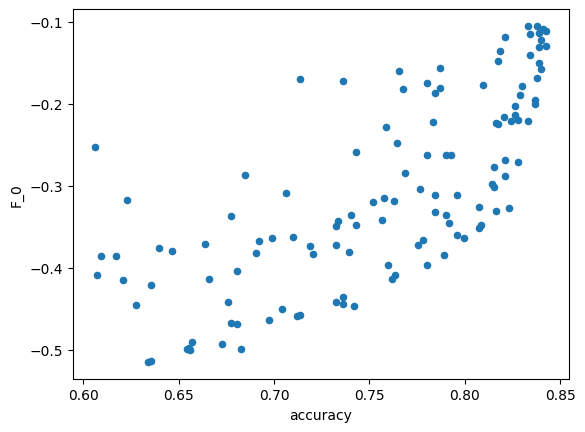

In [17]:
df = df[df['accuracy'] > 0.6]
# print(df.count)
df.plot(kind='scatter', x='accuracy', y='F_0')